/home/aiswarya/miniconda3/lib/python3.9/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/home/aiswarya/miniconda3/lib/python3.9/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


TypeError: print_png() got an unexpected keyword argument 'ec'

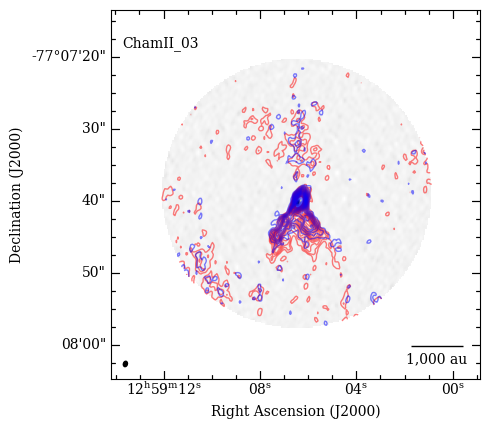

In [3]:
from astropy.io import fits
import astropy.units as u
import numpy as np
import os
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import add_beam, add_scalebar
#from astropy.visualization.wcsaxes.wcs_utils import add_beam, add_scalebar


# from astropy import wcs
from spectral_cube import SpectralCube

import matplotlib.pyplot as plt
plt.ion()

plt.rcParams.update({"text.usetex": False,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.size': 3,
                     'xtick.major.size': 6,
                     'ytick.minor.size': 3,
                     'ytick.major.size': 6,})

def campos_moment_maps(file_in, file_out, 
    vel_min=-10 * u.km/u.s, vel_max=10 * u.km / u.s):
    cube = SpectralCube.read(file_in)
    cube_kms = cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
    subcube = cube_kms.spectral_slab(vel_min, vel_max)
    moment_0 = subcube.moment(order=0)
    moment_0.write(file_out, overwrite=True)

def campos_moment_figure(file_cont, file_out, file_red=None, file_blue=None, 
    rms_red=0.1, rms_blue=0.1, distance=140.0, name=None):
    """
    Red and blue contours are drawn starting at 3-sigma, with a spacing of 2-sigma
    """
    # cmap = plt.get_cmap(name='Grays').copy()
    # cmap.set_bad(color='0.85')

    text_color = 'black'

    fits_hdulist = fits.open(file_cont)
    hd = fits_hdulist[0].header
    wcs = WCS(hd)
    if wcs.naxis == 4:
        wcs = wcs.dropaxis(3)
        wcs = wcs.dropaxis(2)
        data = fits_hdulist[0].data[0][0]
    elif wcs.naxis == 3:
        wcs = wcs.dropaxis(2)
        data = fits_hdulist[0].data[0]
    else:
        data = fits_hdulist[0].data

    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(projection=wcs)#, slices=(0, 0, 'y', 'x'))
    im = ax.imshow(data, origin='lower', cmap='Greys')

    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    # Sets formatting
    ra_ax.set_major_formatter('hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm:ss')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    # set ticks spacing and minor tick paramters
    # ra_ax.set_ticks(spacing=10 * u.arcsec, color=text_color)
    dec_ax.set_ticks(spacing=10 * u.arcsec, color=text_color)
    ra_ax.set_minor_frequency(4)
    dec_ax.set_minor_frequency(4)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.tick_params(color=text_color)
    # Add YSO lists
    ax.autoscale(enable=False)
    # H2 column density contours
    if file_red != None:
        levels = rms_red * np.arange(3, 50, 2)
        hdu = fits.open(file_red)[0]
        ax.contour(hdu.data, levels=levels, 
                   transform=ax.get_transform(WCS(hdu.header)), 
                   colors='red', linewidths=1, alpha=0.5)
    if file_blue != None:
        levels = rms_blue * np.arange(3, 50, 2)
        hdu = fits.open(file_blue)[0]
        ax.contour(hdu.data, levels=levels, 
                   transform=ax.get_transform(WCS(hdu.header)), 
                   colors='blue', linewidths=1, alpha=0.5)
    # Add beamsize
    add_beam(ax, header=hd, frame=False, color="black")
    # Scalebar
    scalebar_angle = (1e3*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
    add_scalebar(ax, scalebar_angle, label="1,000 au", color="black")
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    if name != None:
        ax.text(0.03, 0.9, name, color='black', transform=ax.transAxes)
    #
    plt.tight_layout()
    fig.savefig(file_out, dpi=250, bbox_inches='tight', ec='white')
    print(file_out)




folder_moments = 'moments/'
folder_figure = 'figures/'
if not os.path.exists(folder_moments):
   # Create a new directory because it does not exist
   os.makedirs(folder_moments)
if not os.path.exists(folder_figure):
   # Create a new directory because it does not exist
   os.makedirs(folder_figure)

data_folder = '/home/aiswarya/Desktop/CAMPOS_Analysis_Cham/product/'


outflow_param = {}
#                          name        vred_min  vred_max  vblue_min  vblue_max  rms_red   rms_blue
outflow_param['ChamI_13'] = ['ChamI_13', 5.15,  7.77,  1.81,  4.12,0.0268,0.0268 ] #2
outflow_param['ChamI_01'] = ['ChamI_01', 5.31, 8.96, 0.07,  3.80, 0.027, 0.027] #2
outflow_param['ChamI_02'] = ['ChamI_02', 5.84, 12.90, -2.09,  4.01,0.0524, 0.0524 ] #4 
outflow_param['ChamI_03'] = ['ChamI_03', 5.92, 8.06, 1.55,  3.69, 0.0132, 0.0132] 
outflow_param['ChamI_04'] = ['ChamI_04', 5.36, 8.14, 1.95, 3.69, 0.0138, 0.0138]  
outflow_param['ChamI_05'] = ['ChamI_05', 5.84, 6.87, 1.95, 3.86, 0.01361, 0.01361]  
outflow_param['ChamI_06'] = ['ChamI_06', 5.73, 7.87, 0.65, 3.51, 0.01308,0.01308]  
outflow_param['ChamI_07'] = ['ChamI_07', 5.18, 9.55, -1.40, 3.51, 0.02862, 0.02862]#2 
outflow_param['ChamI_08'] = ['ChamI_08', 5.28, 17.67, -5.82, 4.33, 0.07075, 0.07075] #5
outflow_param['ChamI_09'] = ['ChamI_09', 5.12, 11.55, 2.26, 4.32, 0.0262, 0.0262]  #2                
outflow_param['ChamI_10'] = ['ChamI_10', 5.26, 8.04, 2.08, 3.04, 0.0140, 0.0140] 
outflow_param['ChamI_11'] = ['ChamI_11', 5.13, 7.90, 0.13, 4.49, 0.0140, 0.0140] 
outflow_param['ChamI_12'] = ['ChamI_12', 4.48, 8.92, -3.53, 3.52, 0.02235, 0.02235]#1.5
outflow_param['ChamII_01'] = ['ChamII_01', 3.85, 20.91, -60.75, 2.10, 0.0476, 0.0476] #2 
outflow_param['ChamII_02'] = ['ChamII_02', 3.72, 9.83, -3.26, 1.89, 0.0214, 0.0214] #1.5
outflow_param['ChamII_03'] = ['ChamII_03', 3.56, 8.24, 0.78, 4.68, 0.0144, 0.0144] #1.5

field_i = 'ChamII_03'

name, vred_min, vred_max, vblue_min, vblue_max, rms_red, rms_blue = outflow_param[field_i]

file_in = data_folder + field_i + '.fits'
file_cont = data_folder + field_i + '.cont.fits'

file_red = folder_moments + name + '_12CO_red.fits'
file_blue = folder_moments + name + '_12CO_blue.fits'
file_fig = folder_figure + name + '_12CO_contours.png'

campos_moment_maps(file_in, file_out=file_red, vel_min=vred_min * u.km/u.s, vel_max=vred_max * u.km/u.s)
campos_moment_maps(file_in, file_out=file_blue, vel_min=vblue_min * u.km/u.s, vel_max=vblue_max * u.km/u.s)

campos_moment_figure(file_cont, file_fig, file_red=file_red, file_blue=file_blue, 
    rms_red=rms_red, rms_blue=rms_blue, distance=140.0, name=name)

In [12]:
print(data_folder+file_fig)

/home/aiswarya/Desktop/CAMPOS_Analysis_Cham/product/figures/ChamI_13_12CO_contours.png
